In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.axis('off')
  plt.show()

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS

#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.finetune/', '')
  
import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import algos_factory
from deepiu.seq2seq.rnn_decoder import SeqDecodeMethod

#debug
from deepiu.util import text2ids

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt'
image_model_name='InceptionResnetV2'

FLAGS.model_dir = model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.coverage.finetune/'


if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path, 
                                      model_name=image_model_name)
else:
  image_model = None

import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.3.0


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words


ENCODE_UNK 1


In [2]:
if 'coverage' in model_dir:
  FLAGS.coverage_attention_wrapper = True

FLAGS.image_encoder = 'Rnn'
#FLAGS.showtell_encode_scope = 'encode'
#FLAGS.showtell_decode_scope = 'decode'
FLAGS.image_attention_size = 64 
FLAGS.image_endpoint_feature_name = 'Conv2d_7b_1x1'
FLAGS.image_model = 'InceptionResnetV2'
FLAGS.image_checkpoint_file = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt' 
FLAGS.pre_calc_image_feature = 0 
FLAGS.finetune_image_model = True 
FLAGS.image_features_batch_norm = True 
FLAGS.image_features_drop_out = True
FLAGS.emb_dim = 512 
FLAGS.rnn_hidden_size = 512 
FLAGS.image_feature_len = 1536 * 64
FLAGS.alignment_history = True

beam_size = 10
length_normalization_factor = 0.25

In [3]:
algo = 'show_and_tell'
global_scope = algo
main_scope = 'main'
melt.apps.image_processing.init()
with tf.variable_scope(global_scope):
  with tf.variable_scope(main_scope):
    predictor =  algos_factory.gen_predictor(algo)
    predictor.init_predict_text(decode_method=SeqDecodeMethod.ingraph_beam, 
                                beam_size=beam_size,
                                length_normalization_factor=length_normalization_factor,
                                logprobs_history=True,
                                alignment_history=True)  

predictor.load(FLAGS.model_dir) 

attention_option: luong
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
rnn decoder gen only mode


image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("show_and_tell/main/main/Flatten/Reshape:0", shape=(?, 98304), dtype=float32)


use melt.seq2seq.CoverageBahdanauAttention


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.coverage.finetune/model.ckpt-35.5-311000
restore ok: /home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.coverage.finetune/model.ckpt-35.5-311000


load model ok /home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.coverage.finetune/model.ckpt-35.5-311000 duration: 8.53612709045


In [4]:
def simple_predict(image_path, predictor):
  timer = gezi.Timer('beam search using time')
  img = melt.read_image(image_path)
  if image_model:
    #attention model gen features only
    feature = image_model.gen_features(img) if image_model is not None else img
  else:
    feature = [img]    
  #texts_list, scores_list = predictor.predict_text(feature)
  #timer.print()
  logprobs_history = None 
  alignment_history = None

  l = predictor.predict_text(feature)
  timer.print()
  texts_list, scores_list= l[0], l[1]
  try:
    logprobs_history = l[2]
    alignment_history = l[3]
  except Exception:
    pass

  #print(alignment_history)

  texts = texts_list[0]
  scores = scores_list[0]
  if logprobs_history is not None:
    logprobs = logprobs_history[0]
  else:
    logprobs = [None] * len(texts)
  if alignment_history is not None:
    alignments = alignment_history[0]
  else:
    alignments = [None] * len(texts)
    
  logprob = None 
  alignment = None 
    
  for text, score, logprob, alignment in zip(texts, scores, logprobs, alignments):
    print('align shape', alignment.shape)
    print(ids2text.ids2text(text), score)
    print(text, len(text))
    if logprob is not None:
      print(map(math.exp, logprob))
    #if alignment is not None:
    #  print(alignment)
    #  print(alignment[10], alignment[11], alignment[12])


In [5]:
#simple_predict(image_path, predictor)

In [6]:
def predict(image_path, predictor, length_normalization_factor=0.25, num_show=1):
  img = melt.read_image(image_path)
  if image_model:
    feature = image_model.gen_feature(img) if image_model is not None else img
  else:
    feature = [img]

  timer = gezi.Timer()
  texts, scores, logprobs_history, alignment_history = predictor.predict_text(feature)
  for i, (text, score, logprob, alignment) in enumerate(zip(texts[0], scores[0], logprobs_history[0], alignment_history[0])):
    print(ids2text.ids2text(text), score)

    # Plot images with attention weights
    words = ids2text.ids2words(text) 
    img = ndimage.imread(image_path)
    
    num_features = melt.image.get_num_features(image_model_name)
    dim = int(np.sqrt(num_features))
    #print('dim:', dim)

    n_words = len(words)
    n_words += 1 #for ori image
    w = np.round(np.sqrt(n_words))
    h = np.ceil(np.float32(n_words) / w)
    
    #print(n_words, w, h)
            
    plt.subplot(w, h, 1)
    plt.imshow(img)
    plt.axis('off')

    #img = scipy.misc.imresize(img, (dim, dim))  

    #smooth = True  #TODO smooth = Ture seems not work not back ground pic
    smooth = False
    if i < 10:  
      print('probs', [math.exp(x) for x in logprob])
      for j in range(len(words)):
        #if i == 0:
        #  print(i, j, words[j], alignment[j])
        plt.subplot(w, h, j + 2)
        lab = pinyin.Convert(words[j].decode('utf8').encode('gbk'))
        lab += '(%0.2f)'%math.exp(logprob[j])
        plt.text(0, 1, lab, backgroundcolor='white', fontsize=10)
        plt.text(0, 1, lab, color='black', fontsize=10)
        plt.imshow(img)
        if smooth:
          alpha_img = skimage.transform.pyramid_expand(alignment[j].reshape(dim, dim), upscale=16, sigma=20)
        else:
          alpha_img = skimage.transform.resize(alignment[j].reshape(dim, dim), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
      plt.show()
      #plt.savefig('test%d.pdf'%i)

    print('beam search using time(ms):', timer.elapsed_ms())

In [ ]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: file:///data2/data/ai_challenger/ai_challenger_caption_test1_20170923/caption_test1_images_20170923/0ae41249f45152e1d21a36cb317564ffe91f2d86.jpg


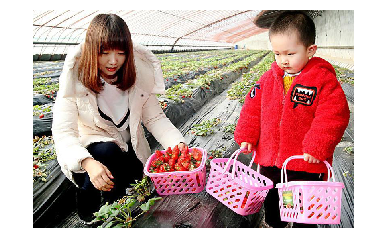

两个 手里 拿 着 篮子 的 女人 蹲 在 大 棚里 </S> 0.0285796
probs [0.21401548223811764, 0.17980427974011148, 0.6138588702170923, 0.996228193461212, 0.502344034870342, 0.9956631023665656, 0.8674783906529573, 0.4890182856345323, 0.9877930212434326, 0.4948286870787336, 0.9976016720900102, 0.5494761711191937, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


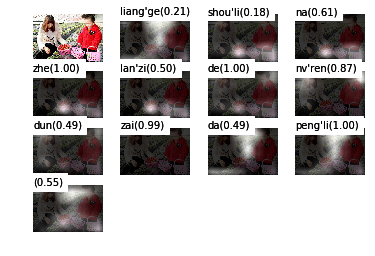

beam search using time(ms): 2546.52810097
大 棚里 有 两个 蹲 着 的 女人 在 采摘 草莓 </S> 0.0265784
probs [0.24563452519453338, 0.9966341678976472, 0.43738926446712006, 0.6106181462486884, 0.1645734509228272, 0.7653591565034613, 0.9962395513096968, 0.8915786922752847, 0.9550423748112089, 0.22816058041210324, 0.7348958922558031, 0.9977380059309073, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


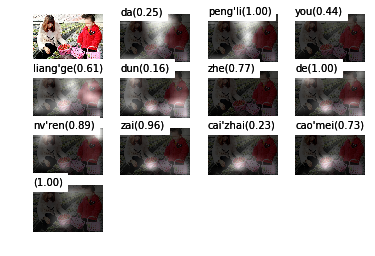

beam search using time(ms): 1096.85611725
大 棚里 有 两个 蹲 着 的 女人 在 摘 草莓 </S> 0.0244987
probs [0.24563452519453338, 0.9966341678976472, 0.43738926446712006, 0.6106181462486884, 0.1645734509228272, 0.7653591565034613, 0.9962395513096968, 0.8915786922752847, 0.9550423748112089, 0.16142681317264185, 0.8914138337464257, 0.9990088044969139, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


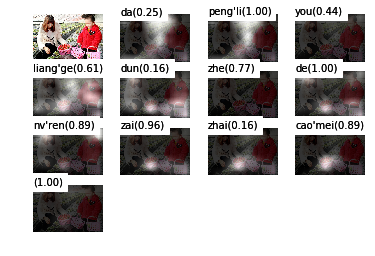

beam search using time(ms): 1195.50895691
两个 手里 拿 着 篮子 的 女人 在 大 棚里 摘 草莓 </S> 0.0197224
probs [0.21401548223811764, 0.17980427974011148, 0.6138588702170923, 0.996228193461212, 0.502344034870342, 0.9956631023665656, 0.8674783906529573, 0.3427167930369862, 0.5902215738644445, 0.9979226916786369, 0.30388318166548334, 0.9271715763073024, 0.9964670036753457, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


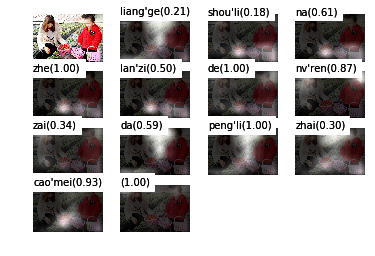

beam search using time(ms): 1146.40283585
大 棚里 有 两个 穿着 长袖 的 女人 在 采摘 草莓 </S> 0.01967
probs [0.24563452519453338, 0.9966341678976472, 0.43738926446712006, 0.6106181462486884, 0.27237045182505054, 0.46048350493628193, 0.5679075297229305, 0.8536090329696635, 0.9530952730145382, 0.24475833686919887, 0.721066879270566, 0.9981351170669942, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


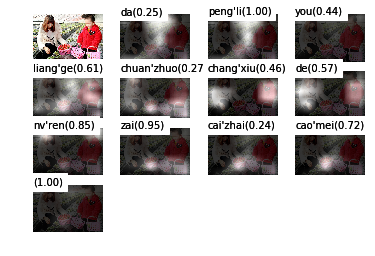

beam search using time(ms): 1202.22711563
两个 手里 拿 着 篮子 的 女人 在 大 棚里 采摘 草莓 </S> 0.0169302
probs [0.21401548223811764, 0.17980427974011148, 0.6138588702170923, 0.996228193461212, 0.502344034870342, 0.9956631023665656, 0.8674783906529573, 0.3427167930369862, 0.5902215738644445, 0.9979226916786369, 0.26022467573141583, 0.8123746262702002, 0.9938824029759539, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


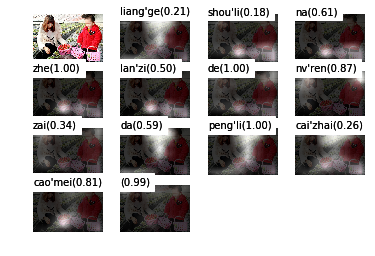

beam search using time(ms): 1267.7628994
两个 手里 拿 着 篮子 的 女人 蹲 在 草莓 园里 </S> 0.0150804
probs [0.21401548223811764, 0.17980427974011148, 0.6138588702170923, 0.996228193461212, 0.502344034870342, 0.9956631023665656, 0.8674783906529573, 0.4890182856345323, 0.9877930212434326, 0.2652628662383553, 0.4793443123360996, 0.649061509892274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


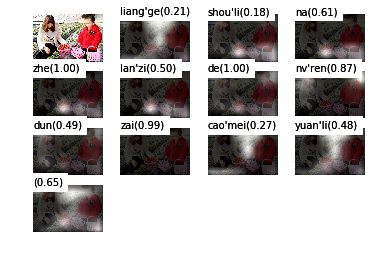

beam search using time(ms): 1103.63197327
两个 手里 拿 着 篮子 的 女人 蹲 在 大 棚里 摘 草莓 </S> 0.0105418
probs [0.21401548223811764, 0.17980427974011148, 0.6138588702170923, 0.996228193461212, 0.502344034870342, 0.9956631023665656, 0.8674783906529573, 0.4890182856345323, 0.9877930212434326, 0.4948286870787336, 0.9976016720900102, 0.06515269288277317, 0.9467040210822917, 0.9978328327409061, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


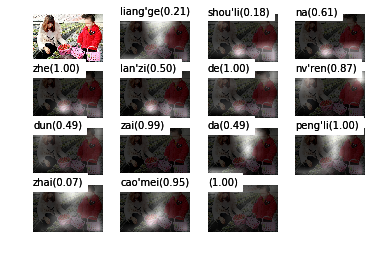

beam search using time(ms): 1240.28921127
两个 手里 拿 着 篮子 的 女人 蹲 在 大 棚里 采摘 草莓 </S> 0.0100097
probs [0.21401548223811764, 0.17980427974011148, 0.6138588702170923, 0.996228193461212, 0.502344034870342, 0.9956631023665656, 0.8674783906529573, 0.4890182856345323, 0.9877930212434326, 0.4948286870787336, 0.9976016720900102, 0.06418934578856243, 0.8710653098543278, 0.9958095460400584, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


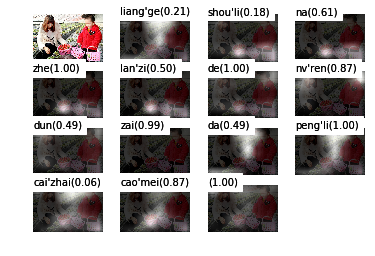

beam search using time(ms): 1313.87281418
一个 穿着 红色 外套 的 女人 和 一个 穿着 红色 外套 的 女人 在 大 棚里 摘 草莓 </S> 0.00995934
probs [0.21302401781885272, 0.14489077546362683, 0.596709894779975, 0.5480623169105249, 0.9960790244109642, 0.8344847654367274, 0.8665016894665595, 0.9833049548035135, 0.4190427779182807, 0.44453893177976966, 0.5967341873177823, 0.9975094986456975, 0.7615950025505536, 0.643217503608803, 0.7040175043282786, 0.9978201327176187, 0.28150852453412695, 0.8643602059746308, 0.9970266087310834, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


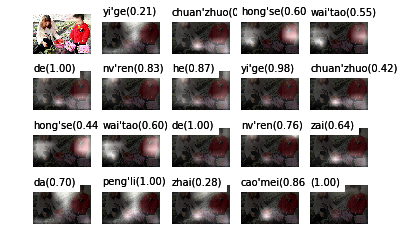

beam search using time(ms): 1645.73812485
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: file:///data2/data/ai_challenger/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/fbbf70826ab1b96cead6209c1da44f1a590da23d.jpg


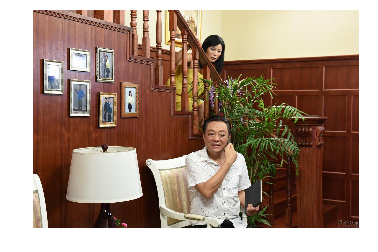

房间 里 有 一个 翘着 二郎腿 的 女人 坐在 椅子 上 </S> 0.05248
probs [0.21431605334244605, 0.9910489527391472, 0.5074402761676523, 0.8652966488320972, 0.09016378286840596, 0.9803259522465128, 0.9798586370398383, 0.896016815069415, 0.7114692525567632, 0.8489412101671662, 0.9889019476245442, 0.9591173288203213, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


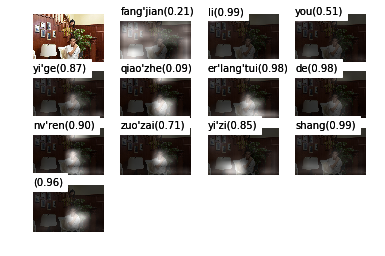

beam search using time(ms): 2212.82696724
房间 里 有 一个 坐在 椅子 上 的 女人 在 打电话 </S> 0.0472359
probs [0.21431605334244605, 0.9910489527391472, 0.5074402761676523, 0.8652966488320972, 0.14624925117482443, 0.8759328168420717, 0.9828888034130898, 0.9888644116816877, 0.8492263684774585, 0.6585299594118764, 0.5253060304843242, 0.9991379069832856, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


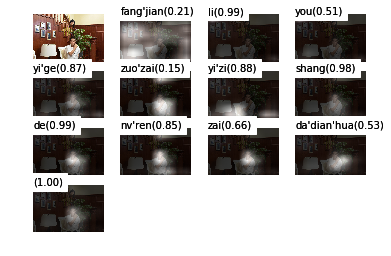

beam search using time(ms): 1540.38405418
房间 里 有 两个 坐在 椅子 上 的 人 在 交谈 </S> 0.036636
probs [0.21431605334244605, 0.9910489527391472, 0.5074402761676523, 0.11228734136304665, 0.45844149121275035, 0.8241268177567379, 0.9865006908666951, 0.9954709826581066, 0.654561437274815, 0.9496776383747849, 0.7620827874804658, 0.9984671759375664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


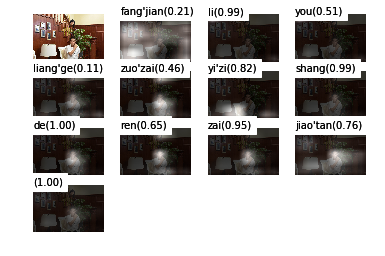

beam search using time(ms): 1745.96405029
屋子里 有 一个 坐在 椅子 上 的 女人 在 打电话 </S> 0.0352924
probs [0.13702185092469643, 0.6544665599100729, 0.8598670904821957, 0.14558906293848242, 0.8546103219045691, 0.990705896600026, 0.9920956241486576, 0.8199111737315191, 0.6075174724670506, 0.48266584918611516, 0.9991229127597034, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


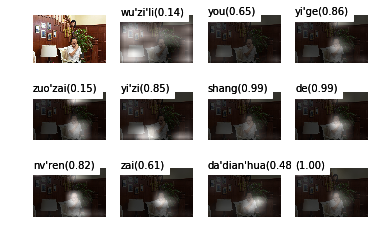

beam search using time(ms): 1196.55489922
一个 穿着 裙子 的 女人 坐在 房间 里 的 椅子 上 </S> 0.0266598
probs [0.2979760290374765, 0.2252860792482918, 0.29431607036163154, 0.9893013892941959, 0.9779019270310096, 0.4464287257736768, 0.19721779870774547, 0.9748369000768857, 0.9656677497224825, 0.8212696152789446, 0.99088424199276, 0.9117382275235127, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


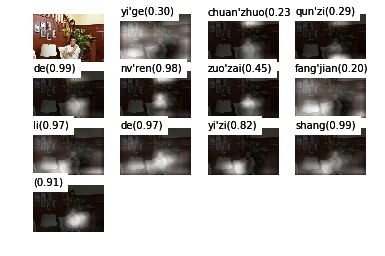

beam search using time(ms): 1346.50921822
房间 里 有 两个 坐在 椅子 上 的 女人 在 交谈 </S> 0.0250171
probs [0.21431605334244605, 0.9910489527391472, 0.5074402761676523, 0.11228734136304665, 0.45844149121275035, 0.8241268177567379, 0.9865006908666951, 0.9954709826581066, 0.32102996451898663, 0.9596836255579461, 0.7556342628157896, 0.9989172036600577, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


beam search using time(ms): 1202.82578468
房间 里 有 一个 坐在 椅子 上 的 女人 和 一个 坐在 椅子 上 的 女人 在 交谈 </S> 0.0151342
probs [0.21431605334244605, 0.9910489527391472, 0.5074402761676523, 0.8652966488320972, 0.14624925117482443, 0.8759328168420717, 0.9828888034130898, 0.9888644116816877, 0.8492263684774585, 0.2207333197652241, 0.9694921057062181, 0.26269353388599154, 0.8564795227692307, 0.98474160281721, 0.9980130415691597, 0.5090295146537723, 0.9470572624966089, 0.7052469721131828, 0.9993101352561375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


beam search using time(ms): 1885.84113121
房间 里 有 一个 坐在 椅子 上 的 女人 和 一个 坐在 椅子 上 的 男人 在 交谈 </S> 0.0138429
probs [0.21431605334244605, 0.9910489527391472, 0.5074402761676523, 0.8652966488320972, 0.14624925117482443, 0.8759328168420717, 0.9828888034130898, 0.9888644116816877, 0.8492263684774585, 0.2207333197652241, 0.9694921057062181, 0.26269353388599154, 0.8564795227692307, 0.98474160281721, 0.9980130415691597, 0.431864387775152, 0.9446251944077564, 0.691885623357388, 0.9992016971328307, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


beam search using time(ms): 1903.63693237
屋子里 有 一个 坐在 椅子 上 的 女人 和 一个 坐在 椅子 上 的 女人 在 交谈 </S> 0.0100782
probs [0.13702185092469643, 0.6544665599100729, 0.8598670904821957, 0.14558906293848242, 0.8546103219045691, 0.990705896600026, 0.9920956241486576, 0.8199111737315191, 0.2466698842895397, 0.9743625788633333, 0.15471618637241766, 0.8702189655320346, 0.9889097585436614, 0.9985368234353432, 0.47016458359768026, 0.9416266353602024, 0.7059563918505855, 0.9993806147707657, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


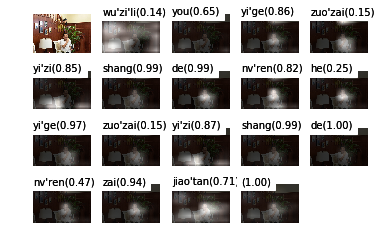

beam search using time(ms): 1861.0329628
屋子里 有 一个 坐在 椅子 上 的 女人 和 一个 坐在 椅子 上 的 男人 在 交谈 </S> 0.00989717
probs [0.13702185092469643, 0.6544665599100729, 0.8598670904821957, 0.14558906293848242, 0.8546103219045691, 0.990705896600026, 0.9920956241486576, 0.8199111737315191, 0.2466698842895397, 0.9743625788633333, 0.15471618637241766, 0.8702189655320346, 0.9889097585436614, 0.9985368234353432, 0.4645930598487489, 0.9405989981769906, 0.6890788943381754, 0.9992640670138454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


beam search using time(ms): 1941.97702408
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: file:///data2/data/ai_challenger/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/fd62aeec3e8a41fc52e327bd89883f73b8a302d7.jpg


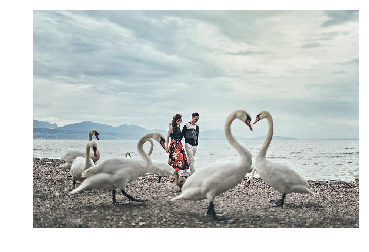

蔚蓝 的 天空 下 有 一群 人站 在 沙滩 上 </S> 0.00968954
probs [0.26982837053677144, 0.9964549302813741, 0.8194557659721615, 0.985620709421556, 0.8254431405434233, 0.23854711561504013, 0.29793084910133333, 0.996302971939123, 0.09108846595587126, 0.9266837259410382, 0.20081276483992977, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


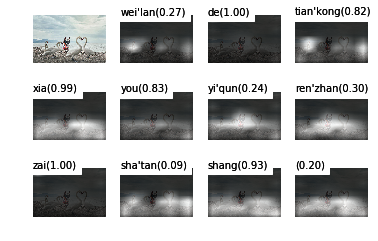

beam search using time(ms): 1857.0599556
蔚蓝 的 天空 下 有 一个 左手 拿 着 东西 的 男人 站 在 沙滩 上 </S> 0.0079032
probs [0.26982837053677144, 0.9964549302813741, 0.8194557659721615, 0.985620709421556, 0.8254431405434233, 0.5459330109920726, 0.10382618669345148, 0.3174243824383211, 0.9212551948473992, 0.3425453265482683, 0.9854654380508379, 0.595238291493007, 0.6923432454766526, 0.9982904859469549, 0.15020575702711045, 0.981217503537983, 0.8858978087684022, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


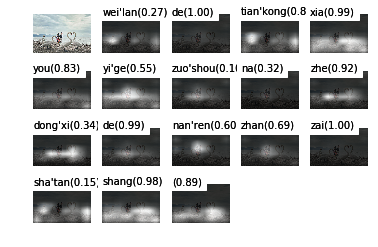

beam search using time(ms): 1561.57207489
蔚蓝 的 天空 下 有 一个 右手 拿 着 东西 的 男人 站 在 沙滩 上 </S> 0.00777167
probs [0.26982837053677144, 0.9964549302813741, 0.8194557659721615, 0.985620709421556, 0.8254431405434233, 0.5459330109920726, 0.09896030767651218, 0.396447920281407, 0.9359901881515192, 0.33529734108359094, 0.9904437601379147, 0.5609732680939836, 0.6891363979611871, 0.9982731411622854, 0.12627083909134484, 0.9818389346749101, 0.9119541067825635, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


beam search using time(ms): 2182.17301369
蔚蓝 的 天空 下 有 一个 右手 抬起 的 男人 站 在 沙滩 上 </S> 0.00732572
probs [0.26982837053677144, 0.9964549302813741, 0.8194557659721615, 0.985620709421556, 0.8254431405434233, 0.5459330109920726, 0.09896030767651218, 0.1509969114515842, 0.9627179271558454, 0.47303853274925195, 0.8117408692999766, 0.9971518803094841, 0.1270308680300142, 0.9843782926203087, 0.9318916333090055, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


beam search using time(ms): 1395.55907249
蔚蓝 的 天空 下 有 一个 右手 拿 着 东西 的 人 站 在 沙滩 上 </S> 0.00554598
probs [0.26982837053677144, 0.9964549302813741, 0.8194557659721615, 0.985620709421556, 0.8254431405434233, 0.5459330109920726, 0.09896030767651218, 0.396447920281407, 0.9359901881515192, 0.33529734108359094, 0.9904437601379147, 0.34268329355348687, 0.6013327057353571, 0.9983081878233154, 0.12166084918038991, 0.9810737137840108, 0.8956535625067836, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


beam search using time(ms): 1611.15193367
蔚蓝 的 天空 下 有 一个 左手 拿 着 东西 的 人 站 在 沙滩 上 </S> 0.00518932
probs [0.26982837053677144, 0.9964549302813741, 0.8194557659721615, 0.985620709421556, 0.8254431405434233, 0.5459330109920726, 0.10382618669345148, 0.3174243824383211, 0.9212551948473992, 0.3425453265482683, 0.9854654380508379, 0.31086031596345715, 0.5955489199138673, 0.9979608003319251, 0.14786041004322897, 0.9792814330491143, 0.8546421082723522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


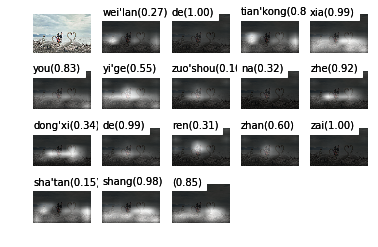

beam search using time(ms): 1497.33304977
蔚蓝 的 天空 下 有 一个 右手 拿 着 相机 的 男人 站 在 沙滩 上 </S> 0.00409199
probs [0.26982837053677144, 0.9964549302813741, 0.8194557659721615, 0.985620709421556, 0.8254431405434233, 0.5459330109920726, 0.09896030767651218, 0.396447920281407, 0.9359901881515192, 0.11230495831843272, 0.9933941941186962, 0.7019377420860721, 0.5723896931237251, 0.9982613803455171, 0.10228355120972137, 0.9766181631613947, 0.8812893287308367, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


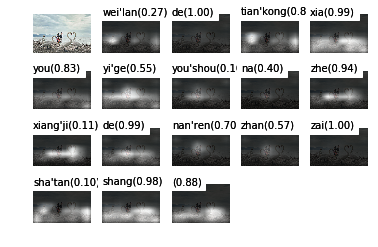

beam search using time(ms): 1532.55200386
蔚蓝 的 天空 下 有 一个 左手 拿 着 东西 的 男人 站 在 蔚蓝 的 海边 </S> 0.00384082
probs [0.26982837053677144, 0.9964549302813741, 0.8194557659721615, 0.985620709421556, 0.8254431405434233, 0.5459330109920726, 0.10382618669345148, 0.3174243824383211, 0.9212551948473992, 0.3425453265482683, 0.9854654380508379, 0.595238291493007, 0.6923432454766526, 0.9982904859469549, 0.10202110173906298, 0.9910345514891331, 0.2762532138878166, 0.9179671730049681, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


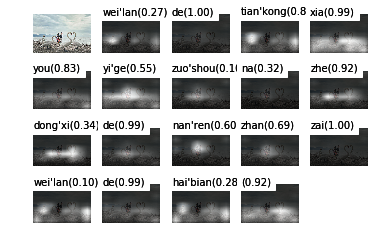

beam search using time(ms): 1546.11682892
蔚蓝 的 天空 下 有 一个 左手 拿 着 东西 的 男人 站 在 蔚蓝 的 天空 下 </S> 0.00370152
probs [0.26982837053677144, 0.9964549302813741, 0.8194557659721615, 0.985620709421556, 0.8254431405434233, 0.5459330109920726, 0.10382618669345148, 0.3174243824383211, 0.9212551948473992, 0.3425453265482683, 0.9854654380508379, 0.595238291493007, 0.6923432454766526, 0.9982904859469549, 0.10202110173906298, 0.9910345514891331, 0.2846054959681911, 0.7292297174250194, 0.9678791922716374, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


beam search using time(ms): 1852.67114639
蔚蓝 的 天空 下 有 一个 右手 拿 着 东西 的 男人 站 在 蔚蓝 的 海边 </S> 0.00348143
probs [0.26982837053677144, 0.9964549302813741, 0.8194557659721615, 0.985620709421556, 0.8254431405434233, 0.5459330109920726, 0.09896030767651218, 0.396447920281407, 0.9359901881515192, 0.33529734108359094, 0.9904437601379147, 0.5609732680939836, 0.6891363979611871, 0.9982731411622854, 0.07928110363220538, 0.9904314818463569, 0.2615689653113439, 0.9135450254739484, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


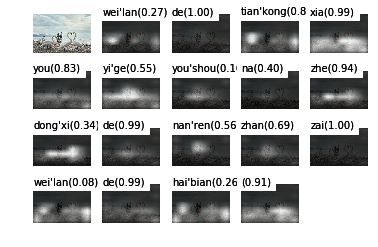

beam search using time(ms): 2050.67586899
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: e427db58e8825be469174d1c88cf223104cfc191


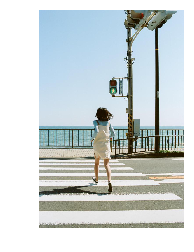

一个 戴着 帽子 的 人 走 在 平坦 的 道路 上 </S> 0.0390935
probs [0.4729209729849083, 0.3638652091013668, 0.6910097337090101, 0.9660570948601682, 0.5648888560089069, 0.16427512526757, 0.9990097562960065, 0.46047148332659305, 0.9873119372052599, 0.49626944311778076, 0.9995331560611515, 0.9979732665337888, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


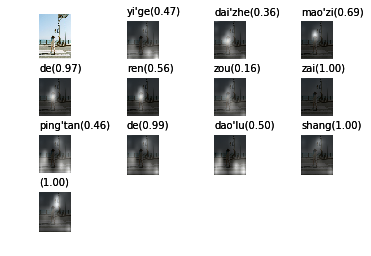

beam search using time(ms): 1971.63295746
一个 戴着 帽子 的 女人 走 在 平坦 的 道路 上 </S> 0.0371036
probs [0.4729209729849083, 0.3638652091013668, 0.6910097337090101, 0.9660570948601682, 0.26786314003539874, 0.3100072775396591, 0.9993010879232876, 0.4228967943163465, 0.992479096340901, 0.5449834702963342, 0.999530416811215, 0.9978150290567277, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


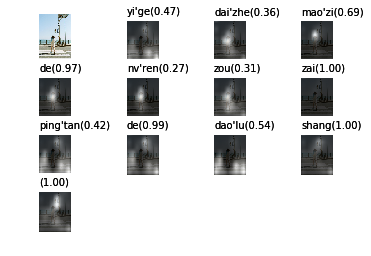

beam search using time(ms): 1250.21505356
一个 戴着 帽子 的 人 在 平坦 的 道路 上 跑步 </S> 0.035589
probs [0.4729209729849083, 0.3638652091013668, 0.6910097337090101, 0.9660570948601682, 0.5648888560089069, 0.6027685362109603, 0.30676130913235133, 0.9727765232814819, 0.5255233715481251, 0.9957512705329677, 0.32959965967686394, 0.9995898499281906, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


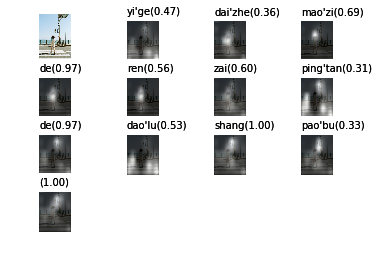

beam search using time(ms): 1192.13700294
一个 戴着 帽子 的 人 走 在 平坦 的 马路上 </S> 0.0327715
probs [0.4729209729849083, 0.3638652091013668, 0.6910097337090101, 0.9660570948601682, 0.5648888560089069, 0.16427512526757, 0.9990097562960065, 0.46047148332659305, 0.9873119372052599, 0.41415068526854, 0.9870633240032762, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


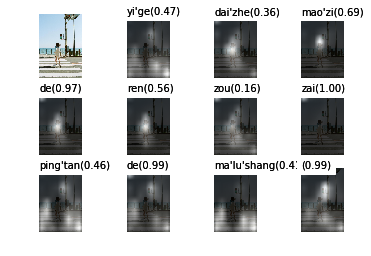

beam search using time(ms): 1605.5021286
平坦 的 道路 上 走 着 一个 戴着 帽子 的 人 </S> 0.0282462
probs [0.1378959958381625, 0.9945762293651712, 0.20926364827992744, 0.9987797149020677, 0.602726322518938, 0.9990834062450976, 0.8715358149177577, 0.28693176687896055, 0.637208221671622, 0.987453143868845, 0.4874669427073813, 0.9886178124771278, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


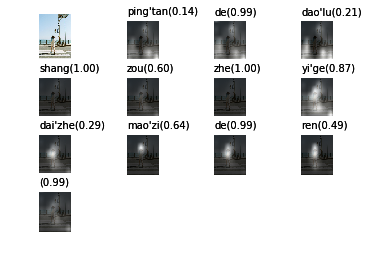

beam search using time(ms): 1229.67886925
一个 戴着 帽子 的 女人 走 在 平坦 的 马路上 </S> 0.0274192
probs [0.4729209729849083, 0.3638652091013668, 0.6910097337090101, 0.9660570948601682, 0.26786314003539874, 0.3100072775396591, 0.9993010879232876, 0.4228967943163465, 0.992479096340901, 0.36170397524822234, 0.988420831644046, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


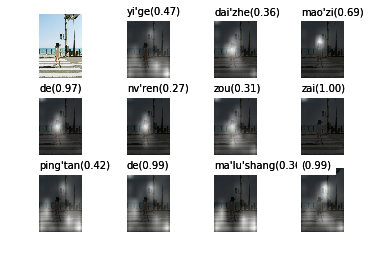

beam search using time(ms): 1103.37495804
平坦 的 马路上 走 着 一个 戴着 帽子 的 人 </S> 0.0272265
probs [0.1378959958381625, 0.9945762293651712, 0.5394487321991239, 0.35506166159110986, 0.9993938308075889, 0.759326659958894, 0.2227502751067509, 0.6692777891502502, 0.9555430187108898, 0.5151253350540562, 0.9653245978588664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


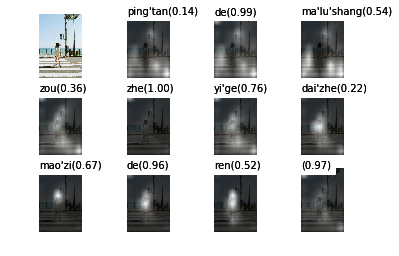

beam search using time(ms): 1165.24600983
平坦 的 道路 上 走 着 一个 戴着 帽子 的 女人 </S> 0.02324
probs [0.1378959958381625, 0.9945762293651712, 0.20926364827992744, 0.9987797149020677, 0.602726322518938, 0.9990834062450976, 0.8715358149177577, 0.28693176687896055, 0.637208221671622, 0.987453143868845, 0.34012183237754423, 0.9854911400709961, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


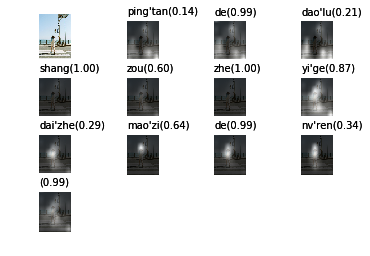

beam search using time(ms): 1270.61295509
平坦 的 马路上 走 着 一个 穿着 白色 上衣 的 人 </S> 0.0226963
probs [0.1378959958381625, 0.9945762293651712, 0.5394487321991239, 0.35506166159110986, 0.9993938308075889, 0.759326659958894, 0.31043714891158775, 0.71629650873007, 0.5121532418678307, 0.9273423362394287, 0.43338056962956023, 0.9547812708069537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


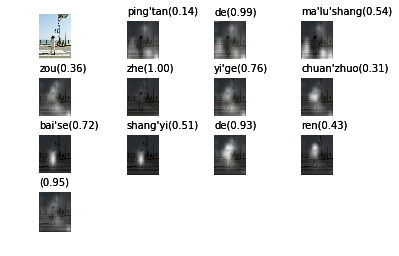

beam search using time(ms): 1312.52002716
平坦 的 马路上 走 着 一个 穿着 白色 上衣 的 女人 </S> 0.019811
probs [0.1378959958381625, 0.9945762293651712, 0.5394487321991239, 0.35506166159110986, 0.9993938308075889, 0.759326659958894, 0.31043714891158775, 0.71629650873007, 0.5121532418678307, 0.9273423362394287, 0.3399827080585739, 0.9449636846028229, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


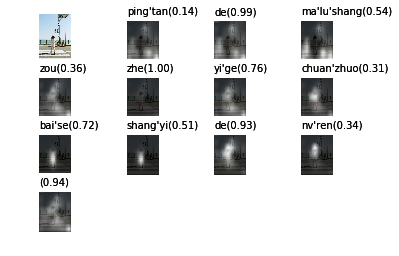

beam search using time(ms): 1206.82096481
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 13bffb7d86bb7a46e356495baa3c6c8179beabd5.jpg


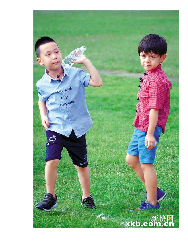

两个 穿着 短裤 的 男孩 在 草地 上 玩耍 </S> 0.0478739
probs [0.28412470710854376, 0.48083208752566486, 0.44278073942621254, 0.9913554583321336, 0.35733303294802116, 0.51650279862744, 0.5843502046801462, 0.9800084824563671, 0.7100300427287388, 0.9990801934573561, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


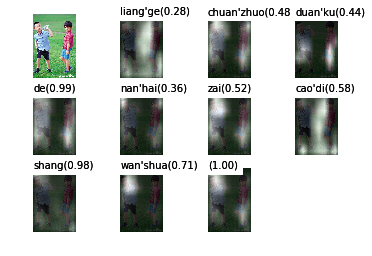

beam search using time(ms): 5353.0228138
两个 穿着 短裤 的 小孩 在 草地 上 玩耍 </S> 0.0403466
probs [0.28412470710854376, 0.48083208752566486, 0.44278073942621254, 0.9913554583321336, 0.2763879713496027, 0.49450164677409125, 0.6077410251408635, 0.9778282890157066, 0.6816429765295808, 0.9990574669108473, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


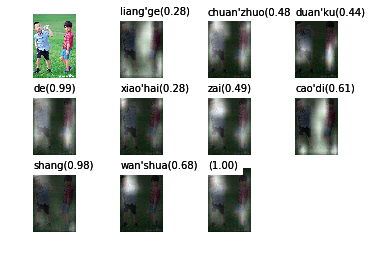

beam search using time(ms): 1505.46717644
两个 穿着 短裤 的 孩子 在 草地 上 玩耍 </S> 0.0360463
probs [0.28412470710854376, 0.48083208752566486, 0.44278073942621254, 0.9913554583321336, 0.22347088964301254, 0.4909960733154373, 0.596360909894345, 0.9790105675163647, 0.7072876768484148, 0.9990391435973681, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


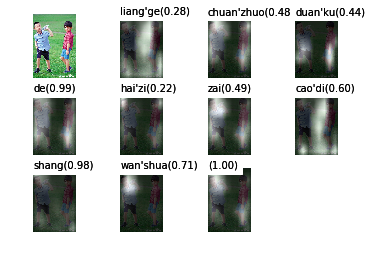

beam search using time(ms): 1634.81688499
两个 穿着 短裤 的 男孩 站 在 草地 上 玩耍 </S> 0.0175159
probs [0.28412470710854376, 0.48083208752566486, 0.44278073942621254, 0.9913554583321336, 0.35733303294802116, 0.23284757247222373, 0.9983592770984806, 0.34774370388199966, 0.9737290954710287, 0.37700551701497315, 0.994513971988746, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


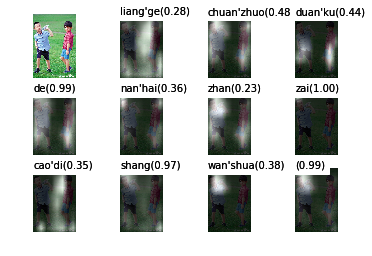

beam search using time(ms): 1583.48894119
绿油油 的 草地 上 站 着 两个 右手 拿 着 瓶子 的 男孩 </S> 0.0159846
probs [0.08741317779944123, 0.9994344335665926, 0.9216416371594623, 0.9848431094284654, 0.20017986626757045, 0.9984804866598562, 0.6488434867874581, 0.16889192504299264, 0.8720733653819241, 0.8341382424466338, 0.6944723548627059, 0.9566829008965102, 0.4035148975762222, 0.9897205359608331, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


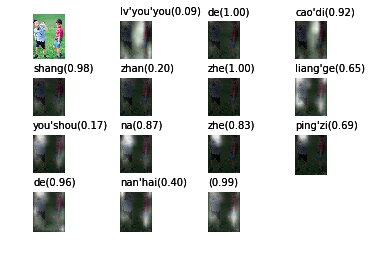

beam search using time(ms): 2089.25104141
两个 穿着 短裤 的 男孩 站 在 草地 上 喝水 </S> 0.0124747
probs [0.28412470710854376, 0.48083208752566486, 0.44278073942621254, 0.9913554583321336, 0.35733303294802116, 0.23284757247222373, 0.9983592770984806, 0.34774370388199966, 0.9737290954710287, 0.20231563349182372, 0.9988232410019683, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


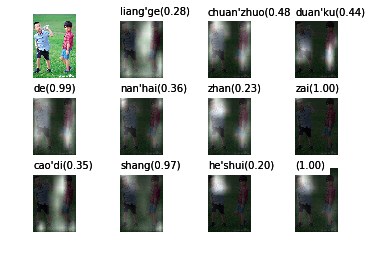

beam search using time(ms): 1643.50008965
绿油油 的 草地 上 站 着 两个 右手 拿 着 瓶子 的 小孩 </S> 0.0121212
probs [0.08741317779944123, 0.9994344335665926, 0.9216416371594623, 0.9848431094284654, 0.20017986626757045, 0.9984804866598562, 0.6488434867874581, 0.16889192504299264, 0.8720733653819241, 0.8341382424466338, 0.6944723548627059, 0.9566829008965102, 0.23664160873885498, 0.9882339413095897, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


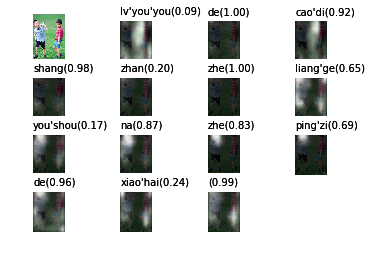

beam search using time(ms): 2023.38695526
绿油油 的 草地 上 站 着 两个 右手 拿 着 瓶子 的 孩子 </S> 0.011979
probs [0.08741317779944123, 0.9994344335665926, 0.9216416371594623, 0.9848431094284654, 0.20017986626757045, 0.9984804866598562, 0.6488434867874581, 0.16889192504299264, 0.8720733653819241, 0.8341382424466338, 0.6944723548627059, 0.9566829008965102, 0.23082012589049597, 0.9902956172293251, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


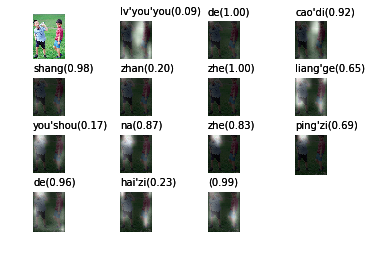

beam search using time(ms): 8970.09706497
草地 上 有 一个 穿着 短裤 的 男孩 看着 一个 在 喝水 的 男孩 </S> 0.0110947
probs [0.22403268221211006, 0.9787432789795091, 0.33802666727454866, 0.8054732044490422, 0.3676956922514754, 0.36639087668981846, 0.9972481369630899, 0.5230003771466479, 0.39193801077039436, 0.9480656360727951, 0.26847507598926795, 0.7634248064511624, 0.9978583524587219, 0.44866597556781684, 0.9939603631064873, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


beam search using time(ms): 1771.85988426
草地 上 有 一个 穿着 短裤 的 男孩 看着 一个 在 喝水 的 孩子 </S> 0.00840171
probs [0.22403268221211006, 0.9787432789795091, 0.33802666727454866, 0.8054732044490422, 0.3676956922514754, 0.36639087668981846, 0.9972481369630899, 0.5230003771466479, 0.39193801077039436, 0.9480656360727951, 0.26847507598926795, 0.7634248064511624, 0.9978583524587219, 0.2600912567486436, 0.9920540901969653, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


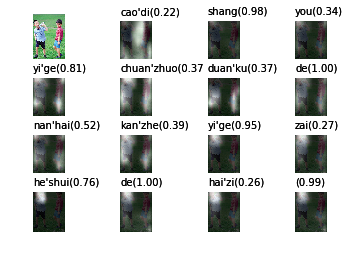

beam search using time(ms): 1924.46208
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: eface8dff3eb8b807cea2eb33fc9b1c2e94a9bd0


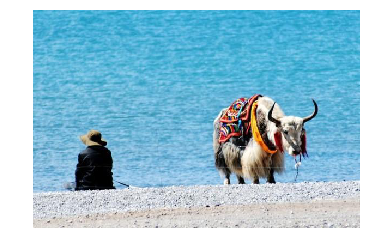

一个 戴着 帽子 的 人 在 水边 的 道路 上 骑马 </S> 0.0289241
probs [0.3560656697594187, 0.4589864889578351, 0.8937347777239284, 0.9842764204949224, 0.8058136548801784, 0.2570038650727542, 0.3232978816254106, 0.9710684706383546, 0.5255889360034214, 0.9918193834766325, 0.2943969528817134, 0.9536458037277624, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


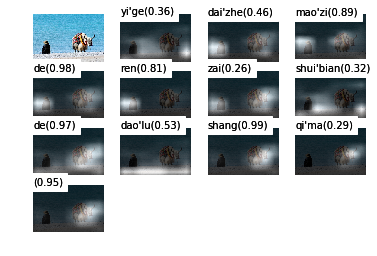

beam search using time(ms): 3605.62300682
一个 戴着 帽子 的 人 牵 着 一只 狗 走 在 湖边 的 道路 上 </S> 0.0217825
probs [0.3560656697594187, 0.4589864889578351, 0.8937347777239284, 0.9842764204949224, 0.8058136548801784, 0.15556276867790253, 0.9992959691259229, 0.43234341240085084, 0.922688630303121, 0.4865213557624869, 0.9990208209107028, 0.2820905251512142, 0.8964918672815402, 0.538086272739486, 0.9997299446884795, 0.9988365612384923, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


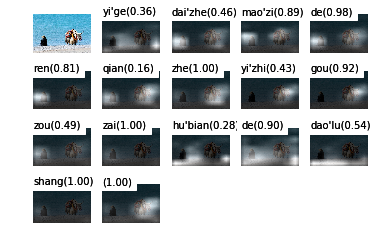

beam search using time(ms): 1715.2299881
一个 戴着 帽子 的 人 站 在 海边 的 道路 上 </S> 0.0217532
probs [0.3560656697594187, 0.4589864889578351, 0.8937347777239284, 0.9842764204949224, 0.8058136548801784, 0.13676931099023648, 0.9863359800285447, 0.3302924250927235, 0.9787577814610064, 0.21674452441281966, 0.999580678401732, 0.7354254228156939, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


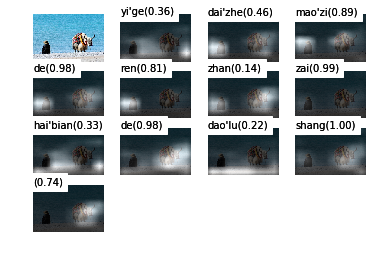

beam search using time(ms): 1342.07701683
一个 戴着 帽子 的 人 牵 着 一只 狗 走 在 海边 的 道路 上 </S> 0.0203376
probs [0.3560656697594187, 0.4589864889578351, 0.8937347777239284, 0.9842764204949224, 0.8058136548801784, 0.15556276867790253, 0.9992959691259229, 0.43234341240085084, 0.922688630303121, 0.4865213557624869, 0.9990208209107028, 0.2549970662790378, 0.9263612738126955, 0.5021654324306176, 0.9997807030106431, 0.9988096832733728, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


beam search using time(ms): 1636.38901711
一个 戴着 帽子 的 人 在 水边 的 道路 上 牵 着 一只 狗 </S> 0.0164932
probs [0.3560656697594187, 0.4589864889578351, 0.8937347777239284, 0.9842764204949224, 0.8058136548801784, 0.2570038650727542, 0.3232978816254106, 0.9710684706383546, 0.5255889360034214, 0.9918193834766325, 0.18872137307343623, 0.9736821922004519, 0.4421719566620926, 0.8154033573933873, 0.9609716610408802, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


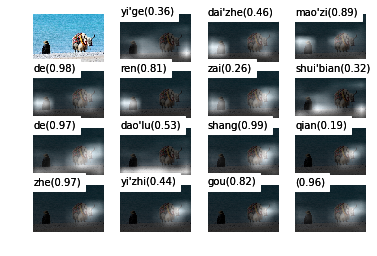

beam search using time(ms): 1592.64206886
一个 戴着 帽子 的 人 在 水边 的 道路 上 牵 着 一条 狗 </S> 0.0138724
probs [0.3560656697594187, 0.4589864889578351, 0.8937347777239284, 0.9842764204949224, 0.8058136548801784, 0.2570038650727542, 0.3232978816254106, 0.9710684706383546, 0.5255889360034214, 0.9918193834766325, 0.18872137307343623, 0.9736821922004519, 0.2777630062691064, 0.9047596965331769, 0.9807719261864278, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


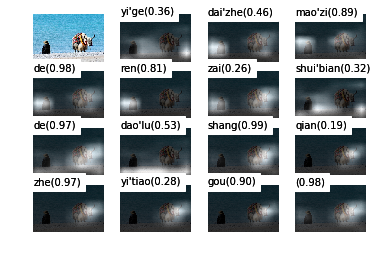

beam search using time(ms): 1587.91899681
一个 戴着 帽子 的 人 牵 着 一只 狗 走 在 湖边 的 台阶 上 </S> 0.0132654
probs [0.3560656697594187, 0.4589864889578351, 0.8937347777239284, 0.9842764204949224, 0.8058136548801784, 0.15556276867790253, 0.9992959691259229, 0.43234341240085084, 0.922688630303121, 0.4865213557624869, 0.9990208209107028, 0.2820905251512142, 0.8964918672815402, 0.20496386197453761, 0.9726437680584109, 0.9995981877869227, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


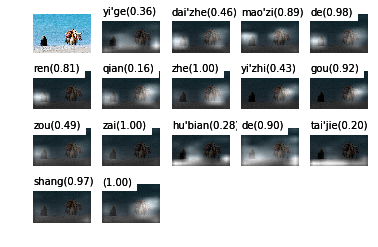

beam search using time(ms): 1628.90601158
一个 戴着 帽子 的 人 牵 着 一只 狗 站 在 海边 的 道路 上 </S> 0.0126184
probs [0.3560656697594187, 0.4589864889578351, 0.8937347777239284, 0.9842764204949224, 0.8058136548801784, 0.15556276867790253, 0.9992959691259229, 0.43234341240085084, 0.922688630303121, 0.2231839501888473, 0.9996293965140844, 0.2882919244001399, 0.9272939521022591, 0.37271766888775026, 0.9997447188878419, 0.9972666317587332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


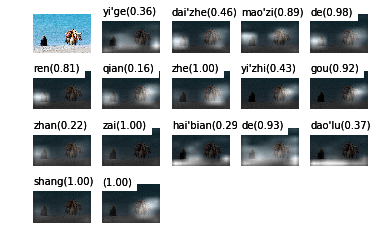

beam search using time(ms): 1475.07095337
一个 戴着 帽子 的 人 牵 着 一条 狗 走 在 湖边 的 道路 上 </S> 0.0125798
probs [0.3560656697594187, 0.4589864889578351, 0.8937347777239284, 0.9842764204949224, 0.8058136548801784, 0.15556276867790253, 0.9992959691259229, 0.15788326573372025, 0.9494159178568573, 0.4658761605135179, 0.9989729948779269, 0.26231826659259067, 0.9040668942827388, 0.5318755799343583, 0.9997263703712387, 0.998897577131706, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


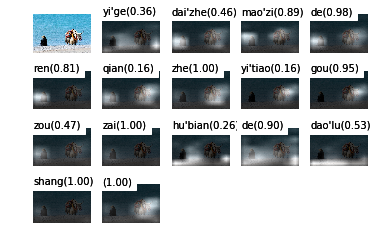

beam search using time(ms): 1704.14590836
一个 戴着 帽子 的 人 牵 着 一只 狗 走 在 海边 的 台阶 上 </S> 0.0119971
probs [0.3560656697594187, 0.4589864889578351, 0.8937347777239284, 0.9842764204949224, 0.8058136548801784, 0.15556276867790253, 0.9992959691259229, 0.43234341240085084, 0.922688630303121, 0.4865213557624869, 0.9990208209107028, 0.2549970662790378, 0.9263612738126955, 0.17799533715266938, 0.9807890126769144, 0.9995370863062278, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


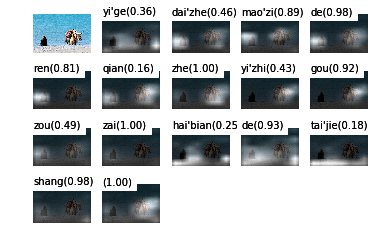

beam search using time(ms): 2607.63001442


In [ ]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: ')
  image_name = image_name.strip().replace('file://', '')
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'

  image_path = os.path.join(image_dir, image_name)

  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    image_path = image_name
    if not os.path.exists(image_path):
        continue
  plt.subplot(1, 1, 1)
  image_show(image_path)
  predict(image_path, predictor)
  #predict(image_path, predictor2, gen_feature=False)

In [ ]:
import glob 
for img in glob.glob('/home/gezi/new2/data/ai_challenger/image_caption/test_pic/*.jpg'):
    image_show(img)
    predict(img, predictor)